## Experiment 2: Surrogate model

In this experiment we focus on how to use our method in the planning phase of a promotion. Let us illustrate the following situation. A retailer is interested in launching a promotion on a cold-start product. During the planning of the promotion the retailer chooses parameters such as the price of the product the type of display. In this experiment we explore five possible combinations of price and type of shelf and discuss how our method produces the forecast and selects the neighbours on a surrogate model.

This data model simulates the sales of 3 SKUs at a country level (constant number of stores) allowing to control the number of times that the product has been on promotion, the baseline sales, the price and discount range, and also the effects on the promotional sales of both the discount and the type of feature display.

We model the baseline sales of each product as a normal distribution $x_{b} \sim \mathcal{N}(\mu_b,\,\sigma^{2}_b)$. We simplify the type of promotions in our model to price cut deals, which allows us to model the discount as a half-normal distribution $x_{d} \sim \left| \mathcal{N}(0,\,\sigma^{2}_b) \right| \in [0, \infty)$. The deal effect curve~\cite{VanHeerde2001Semiparametric}, which connects discount and sales, is modelled as a shifted Gompertz distribution. In this setup, the sales increase with the discount reaching a point where they experience a decay. This saturation is typically observed in stock limited offers. The shifted Gompertz distribution at a time $t$, with scale parameter $b$ and shape parameter $\eta$ that is used in our examples is defined as:

\begin{equation}
f(t; b, \eta) = 1 + \left( 2.2 b e^{-bt} e^{-\eta e^{-bt}} [1 + \eta (1 -e^{-bt})] \right)
\end{equation}

The deal effect curves are can be produced with ADD_NAME, where the blue line represents product P1, a product where discounts do not make a large difference as the product is normally included in the regular basket, for example, produce products.
Product P2 is represented by the orange line, and in this case, the discount rapidly increases the sales up to the point of running out of stock, affecting sales negatively. Finally, in green colour line there is product P3, which represents a real case scenario that we have particularly observed in Asian markets, where there are certain products for which a small price cut can rapidly increase sales. As a byproduct the shelves are empty very quickly resulting in a negative customer experience.

In [21]:
import matplotlib
from mpl_toolkits import mplot3d
import category_encoders as ce
import pandas as pd
import numpy as np
from os import path as _p
from contrastiveRegressor import contrastiveRegressor
from common_metrics import get_frc_errors

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool

import seaborn as sns
import matplotlib.pyplot as plt
import preprocessing_utils as pt
from generate_Gompertz_sales import generate_Gompertz_sales
import fcn_helpers as fhelp


In [22]:

# PRODUCT 1 >> Milk
num_samples = 100
# Baseline sales
mu_sales = 80
sigma_sales = 6
# Price
price_mu = 80
# Discount
discount_sigma = 8.2
# Shelves
shelf_capacity = [12, 10, 8, 6]
shelf_impact = 2.5
# Gompertz
b_scale   = 0.3
eta_shape = 8.0
# Generate sales
df_A = generate_Gompertz_sales(num_samples, mu_sales, sigma_sales,
  price_mu, discount_sigma, shelf_capacity, shelf_impact,
  b_scale, eta_shape)
df_A['product'] = 'P1'
df_A.head()



# PRODUCT 2 >> Chocolates
num_samples = 80
# Baseline sales
mu_sales = 40
sigma_sales = 4.5
# Price
price_mu = 100
# Discount
discount_sigma = 6.0
# Shelves
shelf_capacity = [5, 4, 3, 6]
shelf_impact = 1.5
# Gompertz
b_scale   = 0.3
eta_shape = 8.0
# Generate sales
df_B = generate_Gompertz_sales(num_samples, mu_sales, sigma_sales,
  price_mu, discount_sigma, shelf_capacity, shelf_impact,
  b_scale, eta_shape)
df_B['product'] = 'P2'



# PRODUCT 3 >> Rice in Thailand
num_samples = 95
# Baseline sales
mu_sales = 140
sigma_sales = 8
# Price
price_mu = 62
# Discount
discount_sigma = 1.75
# Shelves
shelf_capacity = [8, 4, 14, 6]
shelf_impact = 1.85
# Gompertz
b_scale   = 0.8
eta_shape = 4.0
# Generate sales
df_C = generate_Gompertz_sales(num_samples, mu_sales, sigma_sales,
  price_mu, discount_sigma, shelf_capacity, shelf_impact,
  b_scale, eta_shape)
df_C['product'] = 'P3'

df = pd.concat([df_A.iloc[:-2, :], df_B.iloc[:-2, :], df_C.iloc[:-2, :]], ignore_index=True)
                
# To evaluate the sugggestion of reviewer #2
df_test_products = pd.concat([df_A.iloc[-2::,:], df_B.iloc[-2::,:], df_C.iloc[-2::,:]], ignore_index=True)

# Save the example so it's reproducible
filePath = _p.join('data', 'toy_example.pickle')
fhelp.toPickleFile(df, filePath)

df

,price,discount,baseline_sales,shelves,shelf_sales,product_sales,product
0,70.153665,9.846335,95.179976,10,13.644415,127.347874,P1
1,71.722759,8.277241,71.722541,10,10.632890,99.240302,P1
2,65.140317,14.859683,81.676392,8,8.327743,95.075062,P1
3,77.096516,2.903484,95.410153,8,9.662003,110.307869,P1
4,77.440119,2.559881,82.796748,6,6.197271,92.270476,P1
...,...,...,...,...,...,...,...
264,61.349086,0.650914,133.592857,8,11.908802,179.543969,P3
265,60.987941,1.012059,137.809421,4,6.976684,203.392336,P3
266,60.611089,1.388911,124.633517,8,13.917665,209.830741,P3
267,60.973640,1.026360,129.490727,4,6.585261,191.981110,P3


In [23]:
df_test_products

,price,discount,baseline_sales,shelves,shelf_sales,product_sales,product
0,67.657449,12.342551,76.115838,8,8.166445,93.233582,P1
1,71.062088,8.937912,83.105298,8,9.740184,111.200434,P1
2,96.267925,3.732075,41.763660,4,1.324375,47.309606,P2
3,96.037492,3.962508,41.406998,4,1.330104,47.514284,P2
4,61.937956,0.062044,137.085722,6,7.628527,150.806580,P3
5,60.336324,1.663676,135.667428,4,7.889803,230.012648,P3


In [24]:
# Test set: aim for regions where the data is pretty scarce 
df_test = pd.DataFrame({'price': [63,65,70,85,95],
  'shelves': [6,13,11,6,10]})

In [25]:
# Variables for the model
responseVar   = 'product_sales'
identifierVar = 'product'

## Model
numerical_vars = ['price']
categoricalVars = ['shelves']
input_vars = numerical_vars + categoricalVars

X_train = df[input_vars].values
y_train = df[responseVar].values

In [26]:
numericalVars = input_vars
categoricalVars = []

num_inputVars = len(input_vars)

# Hyper-parameters
num_neighbours = 5
validation_test_size = 0.20
feat_importance_keyword = 'feature_importances_'
# Regressor
num_iterations = 800
learning_rate  = 0.15
depth = 12
# CatBoost
cb_model = CatBoostRegressor(iterations=num_iterations, learning_rate=learning_rate,
depth=depth, loss_function='RMSE', cat_features=categoricalVars, silent=True)

# Create the forecaster
contrastiveReg = contrastiveRegressor(num_neighbours = num_neighbours, 
  validation_test_size = validation_test_size)

# Set the regressor
contrastiveReg.set_regressor(cb_model, feat_importance_keyword, input_vars)
# fit the regressor
contrastiveReg.fit(X_train, y_train)
# eval results
contrastiveReg.predict_eval_test()
eval_results = contrastiveReg.get_results()

Preparing Training set...
Training set (1075, 4). Evaluation (270, 4)...done.
...Symmetrical Weights
MAE: 4.81
MSE: 43.93
RMSE: 6.63
meanError: -0.45
MAPE: 5.32
R2: 0.99
frc_error: 0.04
frc_bias: -0.00
frc_acc: 1.00
Var explained: 0.99


In [27]:
# Predict
contrastiveReg.predict(df_test.values)
cold_start_results = contrastiveReg.get_results()

...Symmetrical Weights


In [28]:
# Sort by importance
df_feature_importances = cold_start_results.get('df_feat_importances', None)
df_feature_importances.columns = ['variable_importance']
df_feature_importances

,variable_importance
price,88.415754
shelves,11.584246


In [29]:
# Arrange the results in a DF so we can easily plot them
df_frc = df_test.copy()
df_frc['y_hat'] = cold_start_results['y_hat_weighted']


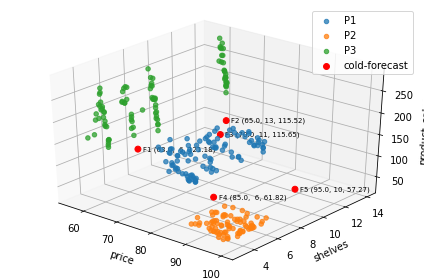

In [30]:
'''
  Checkpoint to see what the sales look like
'''
varX = 'price'
varY = 'shelves'
varZ = 'product_sales'

_alpha = 0.75
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(df_A[varX], df_A[varY], df_A[varZ], alpha=_alpha, label=df_A.loc[0, 'product'])
ax.scatter(df_B[varX], df_B[varY], df_B[varZ], alpha=_alpha, label=df_B.loc[0, 'product'])
ax.scatter(df_C[varX], df_C[varY], df_C[varZ], alpha=_alpha, label=df_C.loc[0, 'product'])
# Also plot the test points
ax.scatter(df_frc[varX], df_frc[varY], df_frc['y_hat'], alpha=1.0, label='cold-forecast', color='red', s=35)

for idx, row in df_frc.iterrows():
    point_name = f'F{(1+idx)} ({row[varX]}, {row[varY]:2.0f}, {row.y_hat:3.2f})'
    ax.text(row[varX]+1.5,row[varY],row['y_hat'], point_name, color='black', fontsize=7)

ax.set_xlabel(varX)
ax.set_ylabel(varY)
ax.set_zlabel(varZ)

ax.view_init(elev=32, azim=-50)
ax.legend()
ax.grid(True)

plt.tight_layout()
#plt.show(block = True)


### Is our method good with products that are regular sellers?

In [31]:
# Predict
contrastiveReg.predict(df_test_products[input_vars].values)
cold_start_results = contrastiveReg.get_results()

...Symmetrical Weights


### Benchmark

In [32]:
df_test_products

,price,discount,baseline_sales,shelves,shelf_sales,product_sales,product
0,67.657449,12.342551,76.115838,8,8.166445,93.233582,P1
1,71.062088,8.937912,83.105298,8,9.740184,111.200434,P1
2,96.267925,3.732075,41.763660,4,1.324375,47.309606,P2
3,96.037492,3.962508,41.406998,4,1.330104,47.514284,P2
4,61.937956,0.062044,137.085722,6,7.628527,150.806580,P3
5,60.336324,1.663676,135.667428,4,7.889803,230.012648,P3


In [33]:
# Predict with CatBoost (original)
y_hat_catboost = fhelp.frc_plain_CatBoost(num_neighbours, validation_test_size,
    num_iterations, learning_rate, depth, \
    contrastiveReg.X_train, contrastiveReg.y_train, df_test_products[input_vars].values)


0:	learn: 64.6339446	test: 55.9453190	best: 55.9453190 (0)	total: 2.82ms	remaining: 2.25s
50:	learn: 8.8140718	test: 15.6067297	best: 15.2337266 (29)	total: 280ms	remaining: 4.11s
100:	learn: 6.2535157	test: 15.2178115	best: 15.0928318 (75)	total: 695ms	remaining: 4.81s
150:	learn: 4.7303246	test: 15.3611074	best: 15.0928318 (75)	total: 1.09s	remaining: 4.69s
200:	learn: 3.7228470	test: 15.4804840	best: 15.0928318 (75)	total: 1.5s	remaining: 4.48s
250:	learn: 2.9726856	test: 15.5445061	best: 15.0928318 (75)	total: 1.91s	remaining: 4.17s
300:	learn: 2.3509702	test: 15.6592729	best: 15.0928318 (75)	total: 2.31s	remaining: 3.82s
350:	learn: 1.9404823	test: 15.7594631	best: 15.0928318 (75)	total: 2.7s	remaining: 3.45s
400:	learn: 1.6150260	test: 15.8362204	best: 15.0928318 (75)	total: 3.12s	remaining: 3.1s
450:	learn: 1.3237670	test: 15.8874664	best: 15.0928318 (75)	total: 3.54s	remaining: 2.74s
500:	learn: 1.0914845	test: 15.9282880	best: 15.0928318 (75)	total: 3.95s	remaining: 2.36s
550

In [34]:
# Predict with Extra Random Trees (sklearn)
y_hat_ERT = fhelp.frc_plain_extratrees(num_neighbours, depth, validation_test_size, 
                                            contrastiveReg.X_train, contrastiveReg.y_train, df_test_products[input_vars].values)

In [35]:
# Predict with NGBoost
y_hat_NGBoost = fhelp.frc_plain_ngboost(num_iterations, learning_rate, validation_test_size, 
                                        contrastiveReg.X_train, contrastiveReg.y_train, 
                                        df_test_products[input_vars].values)

[iter 0] loss=5.6720 val_loss=5.7144 scale=0.0625 norm=3.5929
[iter 100] loss=4.5836 val_loss=4.6138 scale=0.5000 norm=5.9733
[iter 200] loss=2.2890 val_loss=140.4272 scale=1.0000 norm=2.7734
[iter 300] loss=1.6369 val_loss=673.5519 scale=1.0000 norm=1.6055
[iter 400] loss=1.2416 val_loss=2054.8762 scale=0.5000 norm=0.5794
[iter 500] loss=1.2247 val_loss=2139.9809 scale=0.0010 norm=0.0011
[iter 600] loss=1.2247 val_loss=2142.2575 scale=0.0010 norm=0.0011
[iter 700] loss=1.2231 val_loss=2172.2454 scale=0.0010 norm=0.0011


In [36]:
df_test_products['y_hat_catboost'] = y_hat_catboost
df_test_products['y_hat_extratrees'] = y_hat_ERT
df_test_products['y_hat_ngboost'] = y_hat_NGBoost
df_test_products['y_hat_contrastive'] = cold_start_results['y_hat_weighted']
df_test_products

,price,discount,baseline_sales,shelves,shelf_sales,product_sales,product,y_hat_catboost,y_hat_extratrees,y_hat_ngboost,y_hat_contrastive
0,67.657449,12.342551,76.115838,8,8.166445,93.233582,P1,105.355147,96.361342,104.807656,88.449945
1,71.062088,8.937912,83.105298,8,9.740184,111.200434,P1,102.962699,99.464814,109.690940,95.255552
2,96.267925,3.732075,41.763660,4,1.324375,47.309606,P2,42.779823,42.771486,45.085799,44.705640
3,96.037492,3.962508,41.406998,4,1.330104,47.514284,P2,44.192959,46.962145,43.064468,45.062792
4,61.937956,0.062044,137.085722,6,7.628527,150.806580,P3,150.155141,163.388616,154.148774,153.869865
5,60.336324,1.663676,135.667428,4,7.889803,230.012648,P3,238.928284,241.960213,254.031701,238.267838


#### Compare the 4 methods

In [37]:
df_frc_metrics = []
y_test = df_test_products['product_sales']
for model_type in ['contrastive','catboost', 'extratrees', 'ngboost']:
    df_frc_metrics.append(pd.DataFrame(\
       [contrastiveReg.get_frc_errors(y_test, \
        df_test_products['y_hat_' + model_type], False)], \
       index=[model_type]))

df_frc_metrics = pd.concat(df_frc_metrics)
df_frc_metrics

,MAE,MSE,RMSE,meanError,MAPE,R2,frc_error,frc_bias,frc_acc,Var explained
contrastive,6.183742,61.240798,7.825650,2.410917,5.958923,0.984765,0.054556,0.021733,0.978267,0.986211
catboost,6.296247,54.375946,7.374005,-0.716153,6.880389,0.986473,0.055549,-0.006279,1.006279,0.986600
extratrees,7.413873,78.243170,8.845517,-1.805247,6.366706,0.980535,0.065409,-0.015677,1.015677,0.981346
ngboost,7.853073,124.844857,11.173400,-5.125368,6.749329,0.968942,0.069284,-0.043262,1.043262,0.975477
